In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

# Loading & Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train/benign',224))
malign_train = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/train/malig',224))
benign_test = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/test/benign',224))
malign_test = np.array(Dataset_loader('/content/drive/MyDrive/Colab Notebooks/BIOE6306-project/test/malig',224))

100%|██████████| 183/183 [00:51<00:00,  3.53it/s]


# Create Label

In [ ]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

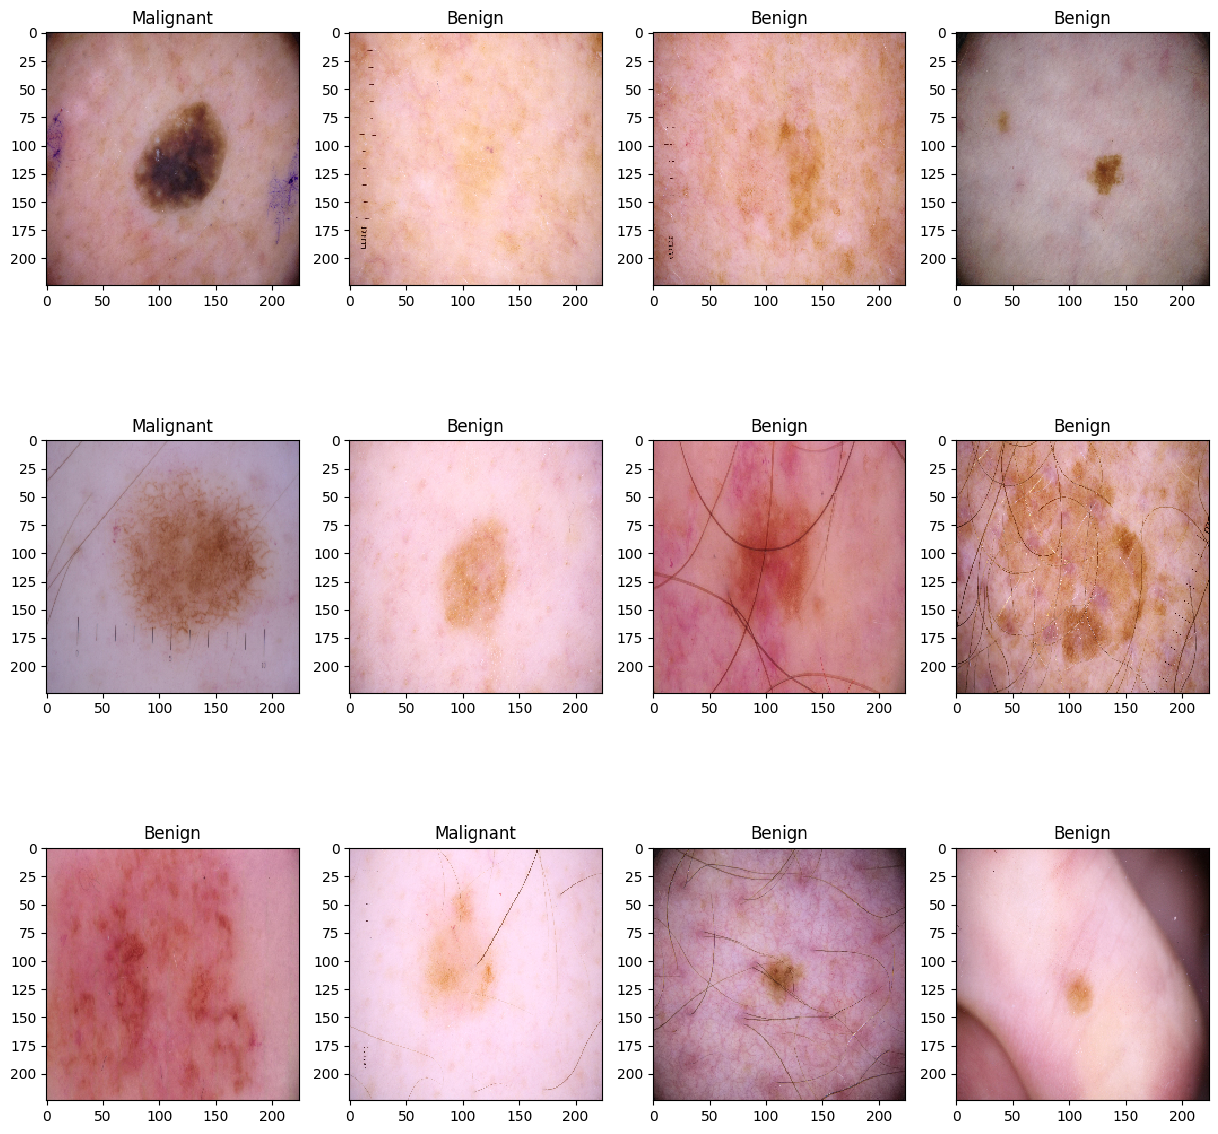

In [ ]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Model: ResNet50

In [ ]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                         

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-11-6994e6891fd9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
44/43 [==============================] - ETA: 0s - loss: 0.8081 - accuracy: 0.5879

43/43 [==============================] - 48s 729ms/step - loss: 0.8081 - accuracy: 0.5879 - val_loss: 0.4384 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 2/50
44/43 [==============================] - ETA: 0s - loss: 0.7263 - accuracy: 0.6538

43/43 [==============================] - 29s 658ms/step - loss: 0.7263 - accuracy: 0.6538 - val_loss: 0.3659 - val_accuracy: 0.8803 - lr: 1.0000e-04
Epoch 3/50
44/43 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.7176

43/43 [==============================] - 29s 657ms/step - loss: 0.6632 - accuracy: 0.7176 - val_loss: 0.3982 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 4/50
44/43 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.7754

43/43 [==============================] - 29s 667ms/step - loss: 0.6046 - accuracy: 0.7754 - val_loss: 0.7403 - val_accuracy: 0.8846 - lr: 1.0000e-04
Epoch 5/50
44/43 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.8214

43/43 [==============================] - 29s 661ms/step - loss: 0.5704 - accuracy: 0.8214 - val_loss: 2.3027 - val_accuracy: 0.8803 - lr: 1.0000e-04
Epoch 6/50
44/43 [==============================] - ETA: 0s - loss: 0.5226 - accuracy: 0.8503

43/43 [==============================] - 29s 666ms/step - loss: 0.5226 - accuracy: 0.8503 - val_loss: 1.0671 - val_accuracy: 0.8989 - lr: 1.0000e-04
Epoch 7/50
44/43 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.8617

43/43 [==============================] - 29s 656ms/step - loss: 0.4625 - accuracy: 0.8617 - val_loss: 0.5074 - val_accuracy: 0.8875 - lr: 1.0000e-04
Epoch 8/50
44/43 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8645

43/43 [==============================] - 29s 661ms/step - loss: 0.4370 - accuracy: 0.8645 - val_loss: 0.3884 - val_accuracy: 0.9003 - lr: 1.0000e-04
Epoch 9/50
44/43 [==============================] - ETA: 0s - loss: 0.4089 - accuracy: 0.8692

43/43 [==============================] - 29s 660ms/step - loss: 0.4089 - accuracy: 0.8692 - val_loss: 1.3720 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 10/50
44/43 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8738

43/43 [==============================] - 29s 665ms/step - loss: 0.3841 - accuracy: 0.8738 - val_loss: 1.4883 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 11/50
44/43 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8856

43/43 [==============================] - 29s 658ms/step - loss: 0.3610 - accuracy: 0.8856 - val_loss: 0.5487 - val_accuracy: 0.9031 - lr: 1.0000e-04
Epoch 12/50
44/43 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.8759

43/43 [==============================] - 29s 658ms/step - loss: 0.3582 - accuracy: 0.8759 - val_loss: 0.5315 - val_accuracy: 0.8960 - lr: 1.0000e-04
Epoch 13/50
44/43 [==============================] - ETA: 0s - loss: 0.3405 - accuracy: 0.8856

43/43 [==============================] - 29s 655ms/step - loss: 0.3405 - accuracy: 0.8856 - val_loss: 0.4087 - val_accuracy: 0.8989 - lr: 1.0000e-04
Epoch 14/50
44/43 [==============================] - ETA: 0s - loss: 0.3151 - accuracy: 0.8920

43/43 [==============================] - 29s 659ms/step - loss: 0.3151 - accuracy: 0.8920 - val_loss: 0.9597 - val_accuracy: 0.8989 - lr: 1.0000e-04
Epoch 15/50
44/43 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8898

43/43 [==============================] - 29s 657ms/step - loss: 0.3226 - accuracy: 0.8898 - val_loss: 4.6464 - val_accuracy: 0.8832 - lr: 1.0000e-04
Epoch 16/50
44/43 [==============================] - ETA: 0s - loss: 0.3081 - accuracy: 0.8955

43/43 [==============================] - 29s 662ms/step - loss: 0.3081 - accuracy: 0.8955 - val_loss: 1.8834 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 17/50
44/43 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8891

43/43 [==============================] - 29s 650ms/step - loss: 0.2943 - accuracy: 0.8891 - val_loss: 1.3051 - val_accuracy: 0.8590 - lr: 1.0000e-04
Epoch 18/50
44/43 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.8888

43/43 [==============================] - 29s 657ms/step - loss: 0.2937 - accuracy: 0.8888 - val_loss: 0.6140 - val_accuracy: 0.9003 - lr: 1.0000e-04
Epoch 19/50
44/43 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.8891

43/43 [==============================] - 29s 662ms/step - loss: 0.2959 - accuracy: 0.8891 - val_loss: 0.3856 - val_accuracy: 0.8946 - lr: 1.0000e-04
Epoch 20/50
44/43 [==============================] - ETA: 0s - loss: 0.2849 - accuracy: 0.8984

43/43 [==============================] - 29s 667ms/step - loss: 0.2849 - accuracy: 0.8984 - val_loss: 0.3193 - val_accuracy: 0.8989 - lr: 1.0000e-04
Epoch 21/50
44/43 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8895

43/43 [==============================] - 29s 649ms/step - loss: 0.2913 - accuracy: 0.8895 - val_loss: 0.2834 - val_accuracy: 0.8960 - lr: 1.0000e-04
Epoch 22/50
44/43 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.9012

43/43 [==============================] - 29s 665ms/step - loss: 0.2612 - accuracy: 0.9012 - val_loss: 0.2716 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 23/50
44/43 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.8998

43/43 [==============================] - 29s 656ms/step - loss: 0.2644 - accuracy: 0.8998 - val_loss: 0.2649 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 24/50
44/43 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.9023

43/43 [==============================] - 29s 654ms/step - loss: 0.2625 - accuracy: 0.9023 - val_loss: 115.3757 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 25/50
44/43 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.8959

43/43 [==============================] - 29s 653ms/step - loss: 0.2614 - accuracy: 0.8959 - val_loss: 5.5943 - val_accuracy: 0.8989 - lr: 1.0000e-04
Epoch 26/50
44/43 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8984

43/43 [==============================] - 29s 657ms/step - loss: 0.2594 - accuracy: 0.8984 - val_loss: 0.5618 - val_accuracy: 0.9003 - lr: 1.0000e-04
Epoch 27/50
44/43 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.8984

43/43 [==============================] - 29s 652ms/step - loss: 0.2520 - accuracy: 0.8984 - val_loss: 0.5907 - val_accuracy: 0.8932 - lr: 1.0000e-04
Epoch 28/50
44/43 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.9027

43/43 [==============================] - 29s 652ms/step - loss: 0.2448 - accuracy: 0.9027 - val_loss: 0.3148 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 29/50
44/43 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9080

43/43 [==============================] - 29s 662ms/step - loss: 0.2506 - accuracy: 0.9080 - val_loss: 0.2801 - val_accuracy: 0.9031 - lr: 1.0000e-04
Epoch 30/50
44/43 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.9027

43/43 [==============================] - 29s 653ms/step - loss: 0.2557 - accuracy: 0.9027 - val_loss: 0.2568 - val_accuracy: 0.9117 - lr: 1.0000e-04
Epoch 31/50
44/43 [==============================] - ETA: 0s - loss: 0.2550 - accuracy: 0.9009

43/43 [==============================] - 29s 656ms/step - loss: 0.2550 - accuracy: 0.9009 - val_loss: 0.3556 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 32/50
44/43 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.9012

43/43 [==============================] - 28s 647ms/step - loss: 0.2649 - accuracy: 0.9012 - val_loss: 0.3388 - val_accuracy: 0.9074 - lr: 1.0000e-04
Epoch 33/50
44/43 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9094

43/43 [==============================] - 29s 662ms/step - loss: 0.2425 - accuracy: 0.9094 - val_loss: 0.2522 - val_accuracy: 0.9074 - lr: 1.0000e-04
Epoch 34/50
44/43 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.9052

43/43 [==============================] - 29s 654ms/step - loss: 0.2386 - accuracy: 0.9052 - val_loss: 0.2453 - val_accuracy: 0.9074 - lr: 1.0000e-04
Epoch 35/50
44/43 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9073

43/43 [==============================] - 29s 649ms/step - loss: 0.2373 - accuracy: 0.9073 - val_loss: 0.2487 - val_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 36/50
44/43 [==============================] - ETA: 0s - loss: 0.2447 - accuracy: 0.9134

43/43 [==============================] - 29s 657ms/step - loss: 0.2447 - accuracy: 0.9134 - val_loss: 0.2741 - val_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 37/50
44/43 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9055

43/43 [==============================] - 29s 656ms/step - loss: 0.2359 - accuracy: 0.9055 - val_loss: 0.2506 - val_accuracy: 0.9046 - lr: 1.0000e-04
Epoch 38/50
44/43 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9137

43/43 [==============================] - 29s 663ms/step - loss: 0.2283 - accuracy: 0.9137 - val_loss: 0.2545 - val_accuracy: 0.9060 - lr: 1.0000e-04
Epoch 39/50
44/43 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9059

43/43 [==============================] - 29s 656ms/step - loss: 0.2432 - accuracy: 0.9059 - val_loss: 0.2907 - val_accuracy: 0.9003 - lr: 1.0000e-04
Epoch 40/50
44/43 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9087

43/43 [==============================] - 29s 650ms/step - loss: 0.2310 - accuracy: 0.9087 - val_loss: 0.2804 - val_accuracy: 0.9003 - lr: 1.0000e-04
Epoch 41/50
44/43 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.9091

43/43 [==============================] - 29s 665ms/step - loss: 0.2338 - accuracy: 0.9091 - val_loss: 0.2686 - val_accuracy: 0.9017 - lr: 1.0000e-04
Epoch 42/50
44/43 [==============================] - ETA: 0s - loss: 0.2250 - accuracy: 0.9144

43/43 [==============================] - 29s 662ms/step - loss: 0.2250 - accuracy: 0.9144 - val_loss: 0.2771 - val_accuracy: 0.9031 - lr: 1.0000e-04
Epoch 43/50
44/43 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9073

43/43 [==============================] - 29s 659ms/step - loss: 0.2179 - accuracy: 0.9073 - val_loss: 0.2945 - val_accuracy: 0.8974 - lr: 1.0000e-04
Epoch 44/50
44/43 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9162

43/43 [==============================] - 29s 659ms/step - loss: 0.2200 - accuracy: 0.9162 - val_loss: 0.2897 - val_accuracy: 0.8960 - lr: 1.0000e-04
Epoch 45/50
44/43 [==============================] - ETA: 0s - loss: 0.2281 - accuracy: 0.9091

43/43 [==============================] - 28s 646ms/step - loss: 0.2281 - accuracy: 0.9091 - val_loss: 0.3123 - val_accuracy: 0.8946 - lr: 1.0000e-04
Epoch 46/50
44/43 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9091

43/43 [==============================] - 29s 650ms/step - loss: 0.2396 - accuracy: 0.9091 - val_loss: 0.2804 - val_accuracy: 0.9031 - lr: 1.0000e-04
Epoch 47/50
44/43 [==============================] - ETA: 0s - loss: 0.2231 - accuracy: 0.9098

43/43 [==============================] - 29s 664ms/step - loss: 0.2231 - accuracy: 0.9098 - val_loss: 0.2542 - val_accuracy: 0.9088 - lr: 1.0000e-04
Epoch 48/50
44/43 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9137

43/43 [==============================] - 29s 665ms/step - loss: 0.2194 - accuracy: 0.9137 - val_loss: 0.3122 - val_accuracy: 0.9003 - lr: 1.0000e-04
Epoch 49/50
44/43 [==============================] - ETA: 0s - loss: 0.2202 - accuracy: 0.9112

43/43 [==============================] - 29s 649ms/step - loss: 0.2202 - accuracy: 0.9112 - val_loss: 0.3092 - val_accuracy: 0.9074 - lr: 1.0000e-04
Epoch 50/50
44/43 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9237

43/43 [==============================] - 29s 659ms/step - loss: 0.2047 - accuracy: 0.9237 - val_loss: 0.3061 - val_accuracy: 0.9003 - lr: 1.0000e-04


In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

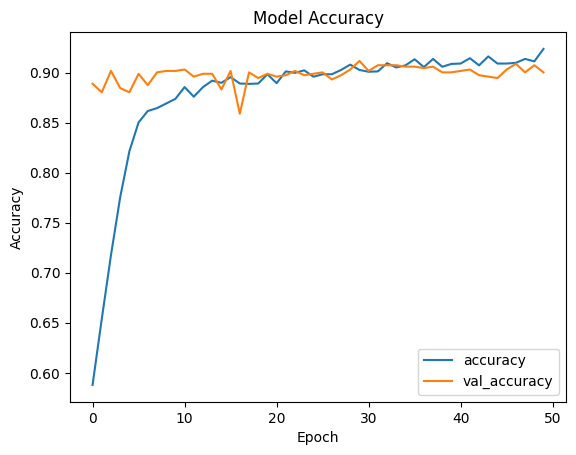

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

<Axes: >

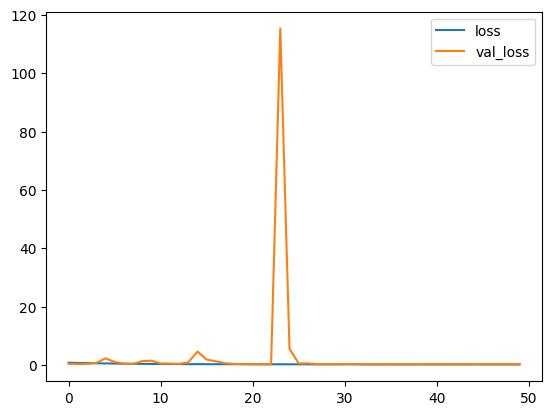

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [ ]:
Y_val_pred = model.predict(x_val)

22/22 [==============================] - 1s 14ms/step


In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9002849002849003

In [ ]:
Y_pred = model.predict(X_test)

56/56 [==============================] - 1s 19ms/step


In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-21-6b1627227319>:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [03:12<00:00, 19.30s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[1595    6]
 [ 178    5]]


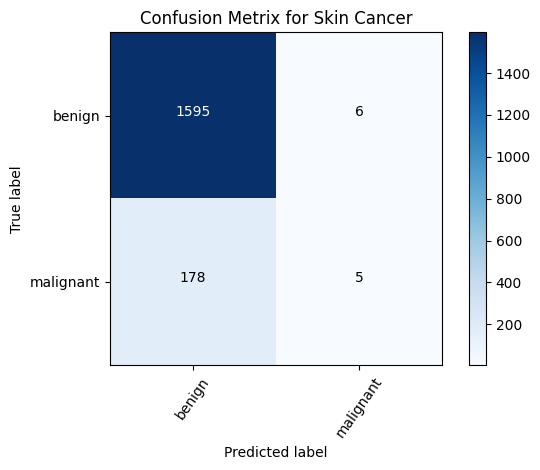

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [ ]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.90      1.00      0.95      1601\n           1       0.47      0.04      0.07       183\n\n    accuracy                           0.90      1784\n   macro avg       0.68      0.52      0.51      1784\nweighted avg       0.86      0.90      0.86      1784\n'

### ROC and AUC

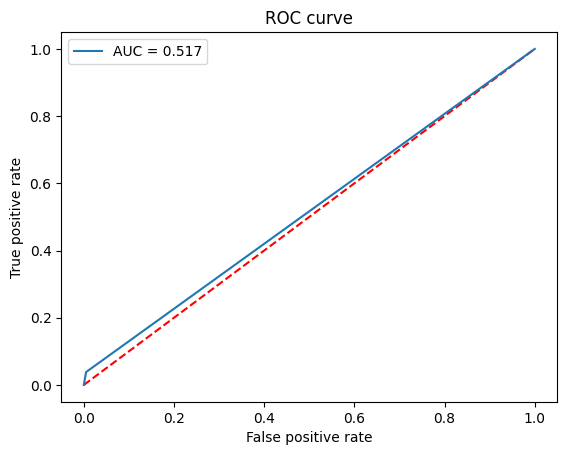

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

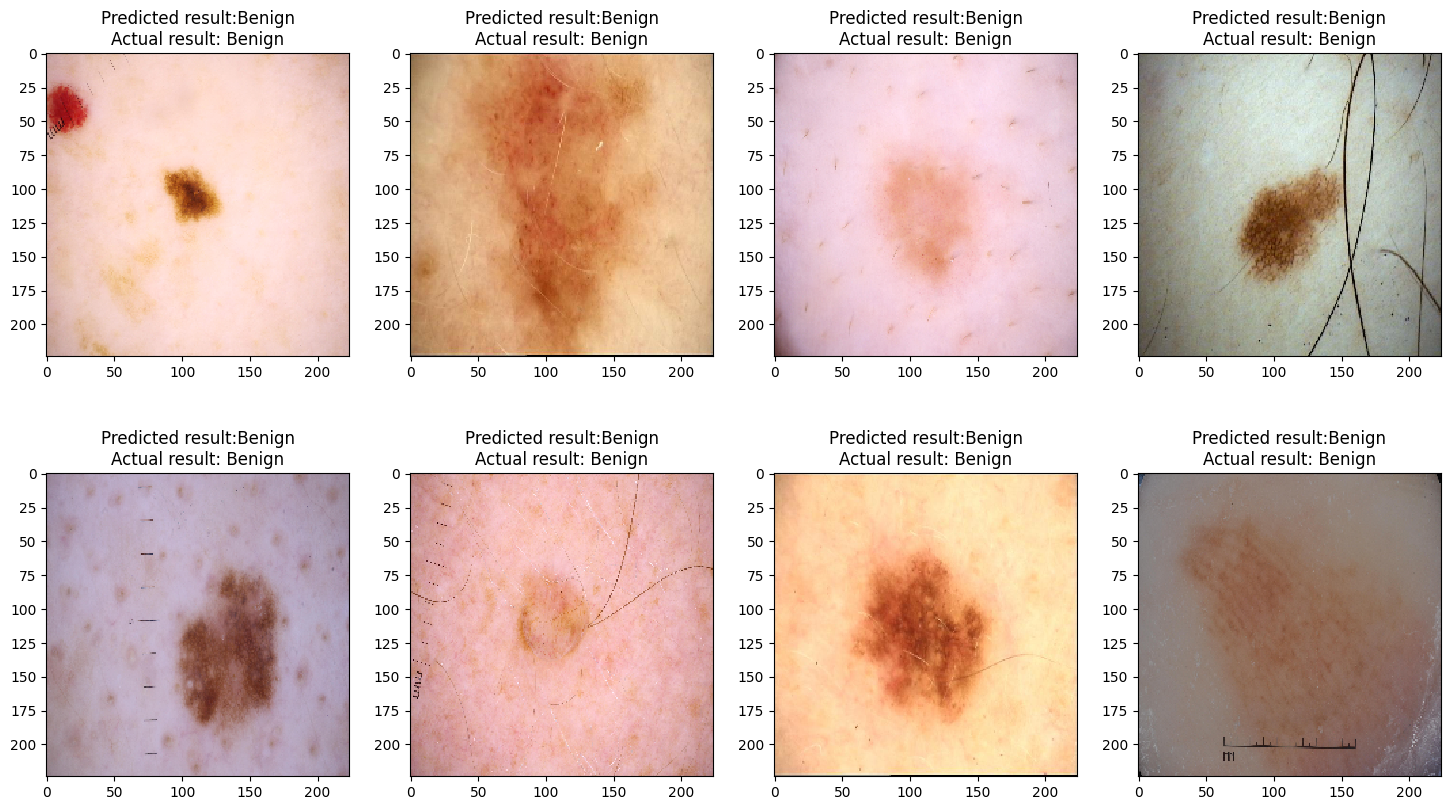

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()